Control Chart Summary:
               Mean  Std Dev      UCL     LCL  Out of Control Points  \
Temperature  24.702    2.246   31.440  17.964                    1.0   
Pressure     99.624    4.662  113.608  85.639                    1.0   
Flow_Rate    50.051    2.918   58.805  41.297                    0.0   
pH_Level      7.260    0.437    8.571   5.950                    1.0   

             Out of Warning Points  Process Capability (Cp)  
Temperature                    2.0                      1.0  
Pressure                       3.0                      1.0  
Flow_Rate                      3.0                      1.0  
pH_Level                       1.0                      1.0  


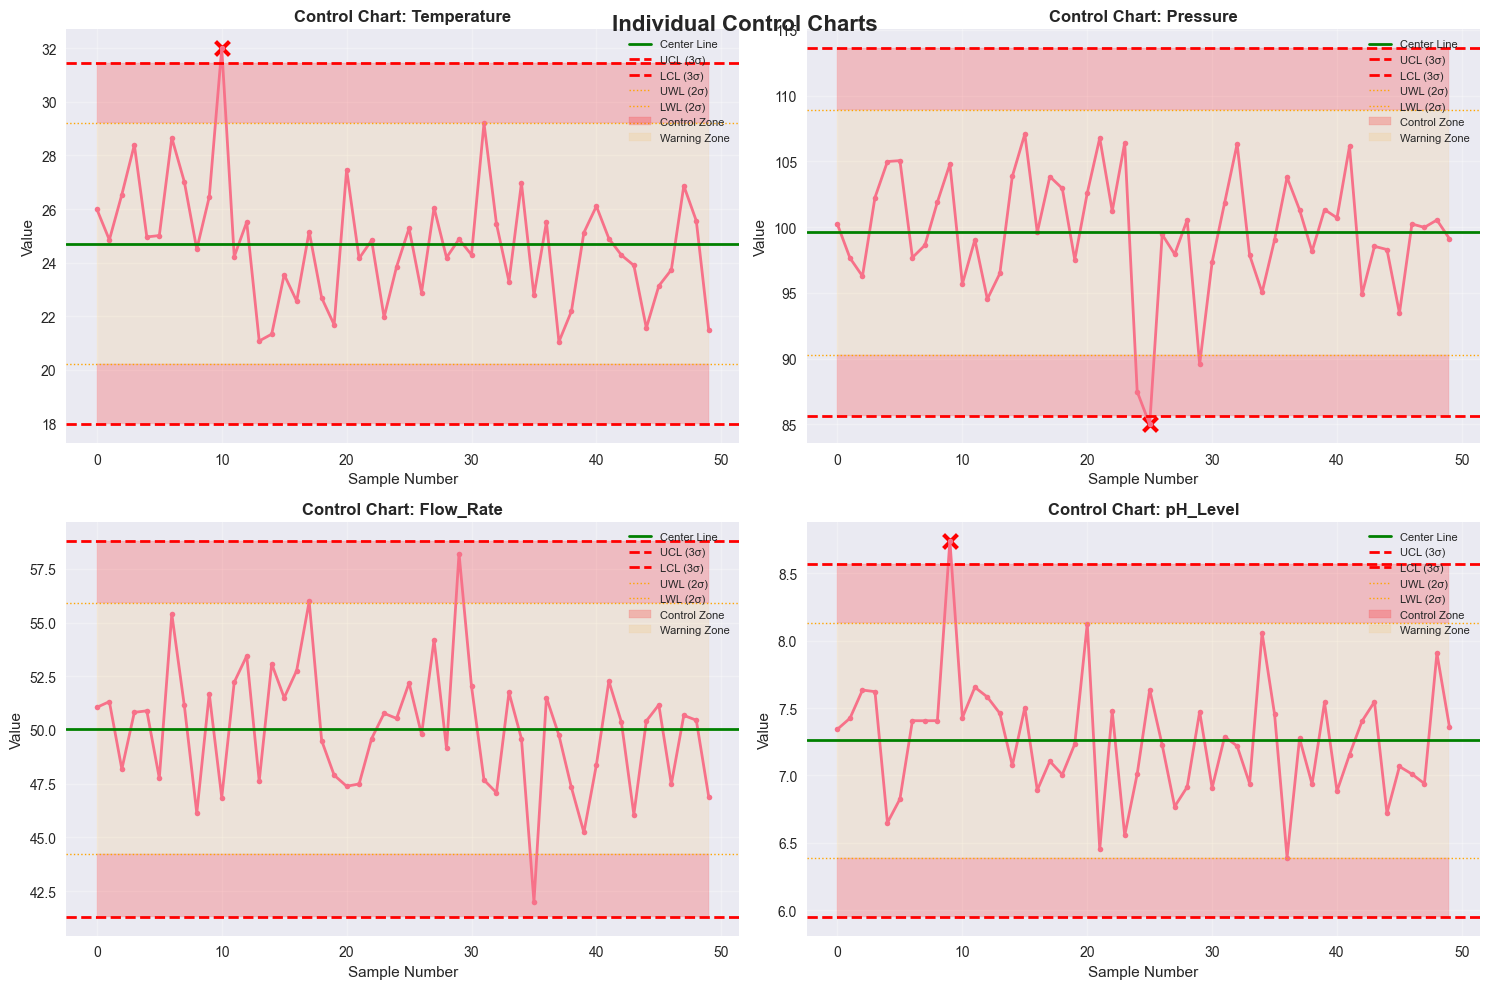

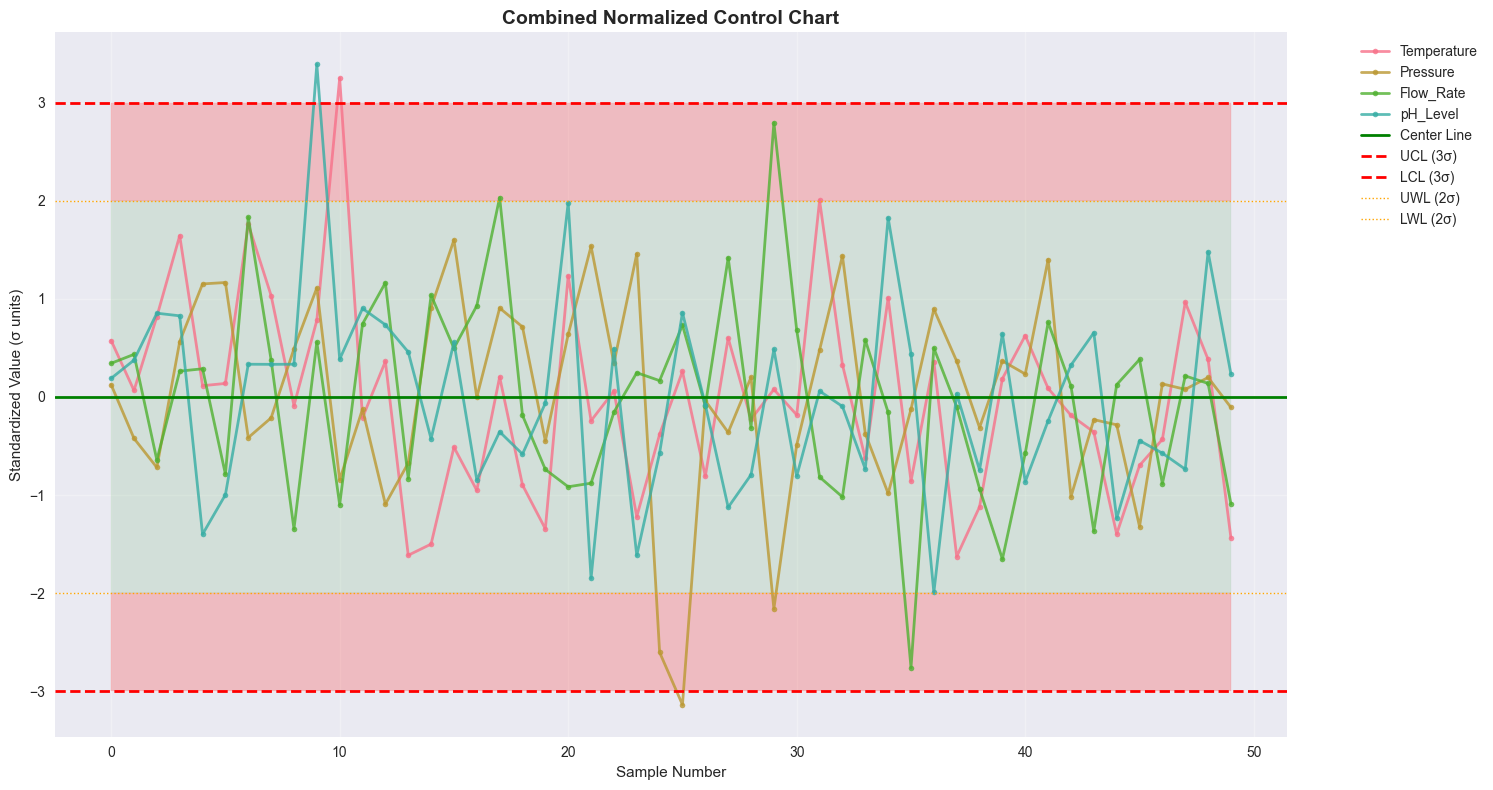

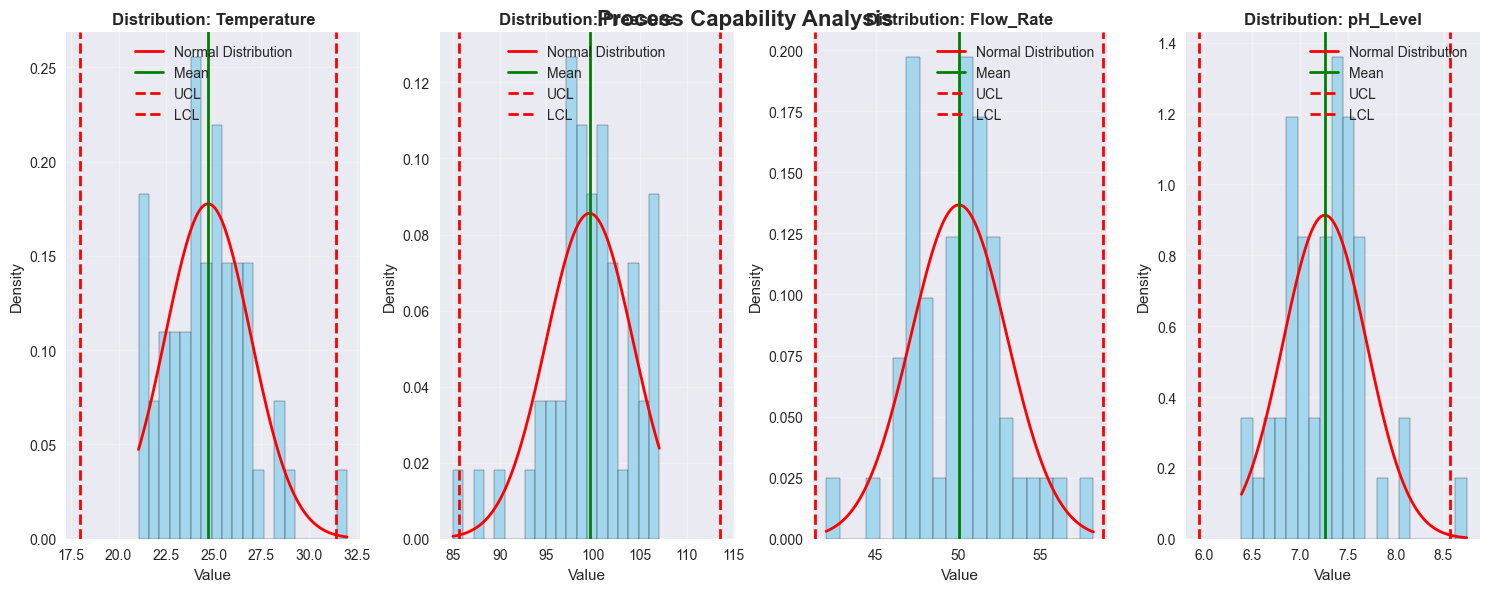

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


class MultiVariableControlChart:

    def __init__(self, data, variable_names=None):
        """
        Initialize control chart with data
        
        Parameters:
        data: pandas DataFrame or numpy array with variables as columns
        variable_names: list of variable names (optional)
        """
        if isinstance(data, np.ndarray):
            self.data = pd.DataFrame(data)
        else:
            self.data = data.copy()

        if variable_names:
            self.data.columns = variable_names
        elif not hasattr(self.data, 'columns'):
            self.data.columns = [
                f'Variable_{i+1}' for i in range(self.data.shape[1])
            ]

        self.n_variables = self.data.shape[1]
        self.n_samples = self.data.shape[0]

        # Calculate control limits for each variable
        self.control_limits = {}
        self.calculate_control_limits()

    def calculate_control_limits(self):
        """Calculate control limits for each variable"""
        for col in self.data.columns:
            mean = self.data[col].mean()
            std = self.data[col].std()

            # Using 3-sigma limits (99.7% confidence)
            ucl = mean + 3 * std  # Upper Control Limit
            lcl = mean - 3 * std  # Lower Control Limit

            # Using 2-sigma limits for warning zones
            uwl = mean + 2 * std  # Upper Warning Limit
            lwl = mean - 2 * std  # Lower Warning Limit

            self.control_limits[col] = {
                'mean': mean,
                'std': std,
                'ucl': ucl,
                'lcl': lcl,
                'uwl': uwl,
                'lwl': lwl
            }

    def plot_individual_charts(self, figsize=(15, 10)):
        """Plot individual control charts for each variable"""
        n_cols = 2
        n_rows = (self.n_variables + 1) // 2

        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        if n_rows == 1:
            axes = axes.reshape(1, -1)

        for i, col in enumerate(self.data.columns):
            row = i // n_cols
            col_idx = i % n_cols
            ax = axes[row, col_idx]

            # Plot data points
            ax.plot(range(self.n_samples),
                    self.data[col],
                    'o-',
                    linewidth=2,
                    markersize=4)

            # Plot control limits
            limits = self.control_limits[col]
            ax.axhline(y=limits['mean'],
                       color='green',
                       linestyle='-',
                       linewidth=2,
                       label='Center Line')
            ax.axhline(y=limits['ucl'],
                       color='red',
                       linestyle='--',
                       linewidth=2,
                       label='UCL (3σ)')
            ax.axhline(y=limits['lcl'],
                       color='red',
                       linestyle='--',
                       linewidth=2,
                       label='LCL (3σ)')
            ax.axhline(y=limits['uwl'],
                       color='orange',
                       linestyle=':',
                       linewidth=1,
                       label='UWL (2σ)')
            ax.axhline(y=limits['lwl'],
                       color='orange',
                       linestyle=':',
                       linewidth=1,
                       label='LWL (2σ)')

            # Fill warning and control zones
            ax.fill_between(range(self.n_samples),
                            limits['uwl'],
                            limits['ucl'],
                            alpha=0.2,
                            color='red',
                            label='Control Zone')
            ax.fill_between(range(self.n_samples),
                            limits['lwl'],
                            limits['lcl'],
                            alpha=0.2,
                            color='red')
            ax.fill_between(range(self.n_samples),
                            limits['lwl'],
                            limits['uwl'],
                            alpha=0.1,
                            color='orange',
                            label='Warning Zone')

            # Identify out-of-control points
            out_of_control = (self.data[col] > limits['ucl']) | (
                self.data[col] < limits['lcl'])
            if out_of_control.any():
                out_points = self.data[col][out_of_control]
                out_indices = np.where(out_of_control)[0]
                ax.scatter(out_indices,
                           out_points,
                           color='red',
                           s=100,
                           marker='x',
                           linewidth=3)

            ax.set_title(f'Control Chart: {col}',
                         fontsize=12,
                         fontweight='bold')
            ax.set_xlabel('Sample Number')
            ax.set_ylabel('Value')
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper right', fontsize=8)

        # Hide empty subplots
        for i in range(self.n_variables, n_rows * n_cols):
            row = i // n_cols
            col_idx = i % n_cols
            axes[row, col_idx].set_visible(False)

        plt.tight_layout()
        plt.suptitle('Individual Control Charts',
                     fontsize=16,
                     fontweight='bold',
                     y=0.98)
        return fig

    def plot_combined_chart(self, figsize=(15, 8)):
        """Plot all variables on a single normalized control chart"""
        fig, ax = plt.subplots(figsize=figsize)

        # Normalize data to z-scores for comparison
        normalized_data = pd.DataFrame()
        for col in self.data.columns:
            mean = self.control_limits[col]['mean']
            std = self.control_limits[col]['std']
            normalized_data[col] = (self.data[col] - mean) / std

        # Plot normalized data
        for i, col in enumerate(normalized_data.columns):
            ax.plot(range(self.n_samples),
                    normalized_data[col],
                    'o-',
                    linewidth=2,
                    markersize=4,
                    label=col,
                    alpha=0.8)

        # Plot control limits (standardized)
        ax.axhline(y=0,
                   color='green',
                   linestyle='-',
                   linewidth=2,
                   label='Center Line')
        ax.axhline(y=3,
                   color='red',
                   linestyle='--',
                   linewidth=2,
                   label='UCL (3σ)')
        ax.axhline(y=-3,
                   color='red',
                   linestyle='--',
                   linewidth=2,
                   label='LCL (3σ)')
        ax.axhline(y=2,
                   color='orange',
                   linestyle=':',
                   linewidth=1,
                   label='UWL (2σ)')
        ax.axhline(y=-2,
                   color='orange',
                   linestyle=':',
                   linewidth=1,
                   label='LWL (2σ)')

        # Fill zones
        ax.fill_between(range(self.n_samples), 2, 3, alpha=0.2, color='red')
        ax.fill_between(range(self.n_samples), -2, -3, alpha=0.2, color='red')
        ax.fill_between(range(self.n_samples), -2, 2, alpha=0.1, color='green')

        ax.set_title('Combined Normalized Control Chart',
                     fontsize=14,
                     fontweight='bold')
        ax.set_xlabel('Sample Number')
        ax.set_ylabel('Standardized Value (σ units)')
        ax.grid(True, alpha=0.3)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        return fig

    def plot_capability_analysis(self, figsize=(15, 6)):
        """Plot capability analysis showing distributions and control limits"""
        fig, axes = plt.subplots(1, self.n_variables, figsize=figsize)
        if self.n_variables == 1:
            axes = [axes]

        for i, col in enumerate(self.data.columns):
            ax = axes[i]

            # Plot histogram
            ax.hist(self.data[col],
                    bins=20,
                    alpha=0.7,
                    density=True,
                    color='skyblue',
                    edgecolor='black')

            # Plot normal distribution overlay
            limits = self.control_limits[col]
            x = np.linspace(self.data[col].min(), self.data[col].max(), 100)
            normal_curve = stats.norm.pdf(x, limits['mean'], limits['std'])
            ax.plot(x,
                    normal_curve,
                    'r-',
                    linewidth=2,
                    label='Normal Distribution')

            # Plot control limits as vertical lines
            ax.axvline(limits['mean'],
                       color='green',
                       linestyle='-',
                       linewidth=2,
                       label='Mean')
            ax.axvline(limits['ucl'],
                       color='red',
                       linestyle='--',
                       linewidth=2,
                       label='UCL')
            ax.axvline(limits['lcl'],
                       color='red',
                       linestyle='--',
                       linewidth=2,
                       label='LCL')

            ax.set_title(f'Distribution: {col}', fontweight='bold')
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
            ax.legend()
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.suptitle('Process Capability Analysis',
                     fontsize=16,
                     fontweight='bold',
                     y=0.98)
        return fig

    def get_control_summary(self):
        """Generate summary statistics and out-of-control points"""
        summary = {}

        for col in self.data.columns:
            limits = self.control_limits[col]
            out_of_control = (self.data[col] > limits['ucl']) | (
                self.data[col] < limits['lcl'])
            out_of_warning = (self.data[col] > limits['uwl']) | (
                self.data[col] < limits['lwl'])

            summary[col] = {
                'Mean':
                limits['mean'],
                'Std Dev':
                limits['std'],
                'UCL':
                limits['ucl'],
                'LCL':
                limits['lcl'],
                'Out of Control Points':
                out_of_control.sum(),
                'Out of Warning Points':
                out_of_warning.sum(),
                'Process Capability (Cp)':
                (limits['ucl'] - limits['lcl']) / (6 * limits['std'])
            }

        return pd.DataFrame(summary).T


# Example usage and demonstration
def create_sample_data():
    """Create sample data for demonstration"""
    np.random.seed(42)
    n_samples = 50

    # Create correlated variables with different means and variances
    data = {
        'Temperature':
        np.random.normal(25, 2, n_samples) +
        0.5 * np.sin(np.linspace(0, 4 * np.pi, n_samples)),
        'Pressure':
        np.random.normal(100, 5, n_samples) +
        np.random.normal(0, 1, n_samples),
        'Flow_Rate':
        np.random.normal(50, 3, n_samples) +
        0.3 * np.cos(np.linspace(0, 6 * np.pi, n_samples)),
        'pH_Level':
        np.random.normal(7.2, 0.4, n_samples)
    }

    # Add some out-of-control points
    data['Temperature'][10] = 32  # High temperature
    data['Pressure'][25] = 85  # Low pressure
    data['Flow_Rate'][35] = 42  # Low flow rate

    return pd.DataFrame(data)


if __name__ == "__main__":
    # Create sample data
    sample_data = create_sample_data()

    # Create control chart object
    control_chart = MultiVariableControlChart(sample_data)

    # Generate plots
    fig1 = control_chart.plot_individual_charts()
    fig2 = control_chart.plot_combined_chart()
    fig3 = control_chart.plot_capability_analysis()

    # Print summary
    print("Control Chart Summary:")
    print("=" * 50)
    summary = control_chart.get_control_summary()
    print(summary.round(3))

    # Show plots
    plt.show()